# **Prédiction de la fraude en assurance automobile**

Par :  Pierre Arielle - Nicolas Garance - Bonfil Keren - Diallo Mamadou - Monote Karène
### Problématique :

## Introduction
La fraude en assurance automobile constitue un enjeu majeur pour les compagnies d’assurance et pour le bon fonctionnement du marché de l’assurance. Elle correspond à toute tentative intentionnelle d’obtenir une indemnisation injustifiée ou excessive à partir d’une déclaration de sinistre. Dans le domaine de l’assurance automobile, les fraudes peuvent prendre différentes formes, comme la mise en scène d’accidents fictifs, l’exagération des dommages matériels ou corporels, la dissimulation d’informations importantes ou encore la déclaration de faux sinistres.


La fraude représente un coût économique significatif pour les assureurs. Les indemnisations frauduleuses augmentent les dépenses des compagnies d’assurance, ce qui se répercute indirectement sur les assurés sous la forme de primes plus élevées. Par conséquent, la lutte contre la fraude constitue un enjeu à la fois économique, actuariel et social, car une mauvaise détection entraîne une dégradation de la rentabilité des assureurs et une hausse du coût de l’assurance pour l’ensemble des assurés. Une détection efficace de la fraude permet donc d'améliorer la qualité des modèles de tarification et de provisionnement.

C’est pourquoi il est essentiel de mettre en place des modèles prédictifs performants capables d’identifier les comportements frauduleux. L’objectif de ce projet est donc de déterminer le modèle de deep learning le plus efficace pour détecter la fraude en assurance automobile sur une base de données réelle.


## Description du dataset

Le projet utilise la base de données  : [Vehicule Insurance Claim Fraud Detection](https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection) disponible sur Kaggle.


In [5]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

In [6]:
# @title
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/fraud_oracle.csv'
df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# @title
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


Ce dataset contient des informations sur des sinistres automobiles, incluant :

caractéristiques du véhicule

*   caractéristiques du véhicule (VehiculeCategory, VehiculePrice
*   informations sur le conducteur (Sexe, Age...)
*   détails de l'accident
*   information sur la police d'assurance
*   informations sur la réclamation

Chaque observation correspond à une déclaration de sinistre automobile.

In [8]:
print(f"Dimensions du dataset : {df.shape[0]} lignes et {df.shape[1]} colonnes\n")


Dimensions du dataset : 15420 lignes et 33 colonnes



La base de données contient environ :


*   15 421 observations
*   33 variables explicatives
*   1 variable cible appelée **FraudFound_P**

Si FraudFound_P = 1 alors il y a fraude,
Sinon si FraudFound_P = 0, non fraude.

Il s'agit donc d'un problème de classification binaire.



### Types de variables

Les variables peuvent être regroupées en plusieurs catégories :

1. Variables temporelles
  + Month

  + WeekOfMonth

  + DayOfWeek

  + MonthClaimed

  + WeekOfMonthClaimed

Ces variables décrivent la date du sinistre et de la déclaration.

2. Variables véhicule

+ VehicleCategory

+ VehiclePrice

+ Make

+ AgeOfVehicle

+ NumberOfCars

Ces variables décrivent les caractéristiques du véhicule assuré.


3. Variables conducteur
+ Age

+ Sex

+ MaritalStatus

+ DriverRating

Ces variables décrivent le profil du conducteur

4. Variables accident

+ AccidentArea

+ PoliceReportFiled

+ WitnessPresent

Ces variables décrivent les circonstances de l’accident.

5. Variables assurance et sinistre

+ PolicyType

+ BasePolicy

+ Deductible

+ PastNumberOfClaims

+ Days_Policy_Accident

+ Days_Policy_Claim

Ces variables décrivent les caractéristiques du contrat et du sinistre.


### Déséquilibre des classes

In [9]:
print("Distribution de la fraude :")
print(df['FraudFound_P'].value_counts(normalize=False))

Distribution de la fraude :
FraudFound_P
0    14497
1      923
Name: count, dtype: int64


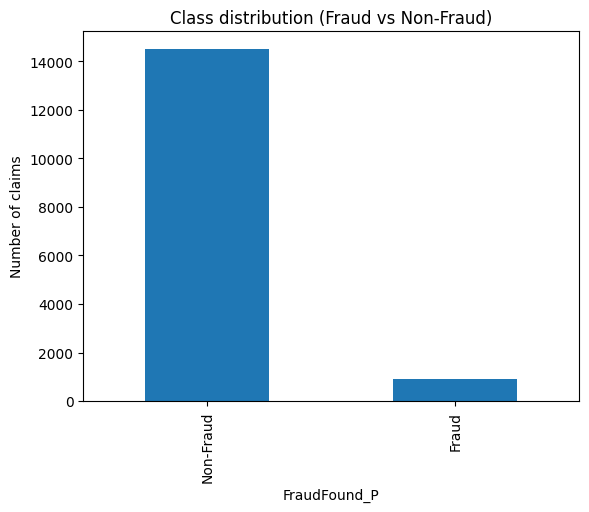

In [10]:
class_counts = df['FraudFound_P'].value_counts()

# Histogramme
plt.figure()
class_counts.plot(kind='bar')

plt.xlabel("FraudFound_P")
plt.ylabel("Number of claims")
plt.title("Class distribution (Fraud vs Non-Fraud)")

plt.xticks([0,1], ['Non-Fraud', 'Fraud'])

plt.show()

Un aspect important de ce dataset est le déséquilibre des classes :
+ 14 497 sinistres non frauduleux
+ 923 sinistres frauduleux
Soit environ 6% de fraudes seulement.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [12]:
df.describe(include="all")

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
count,15420,15420.000000,15420,15420,15420,15420,15420,15420.000000,15420,15420,...,15420,15420,15420,15420,15420,15420,15420,15420,15420.000000,15420
unique,12,NaN,7,19,2,8,13,NaN,2,4,...,8,9,2,2,2,4,5,5,NaN,3
top,Jan,NaN,Monday,Pontiac,Urban,Monday,Jan,NaN,Male,Married,...,7 years,31 to 35,No,No,External,none,no change,1 vehicle,NaN,Collision
freq,1411,NaN,2616,3837,13822,3757,1446,NaN,13000,10625,...,5807,5593,14992,15333,15179,7047,14324,14316,NaN,5962
mean,NaN,2.788586,NaN,NaN,NaN,NaN,NaN,2.693969,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.866472,NaN
std,NaN,1.287585,NaN,NaN,NaN,NaN,NaN,1.259115,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.803313,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.000000,NaN
25%,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.000000,NaN
50%,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995.000000,NaN
75%,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.000000,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

On transforme code d'identification de l'employé en variable catégorielle.

In [14]:
df['RepNumber'] = df['RepNumber'].astype('object')

Affichages de quelques graphiques

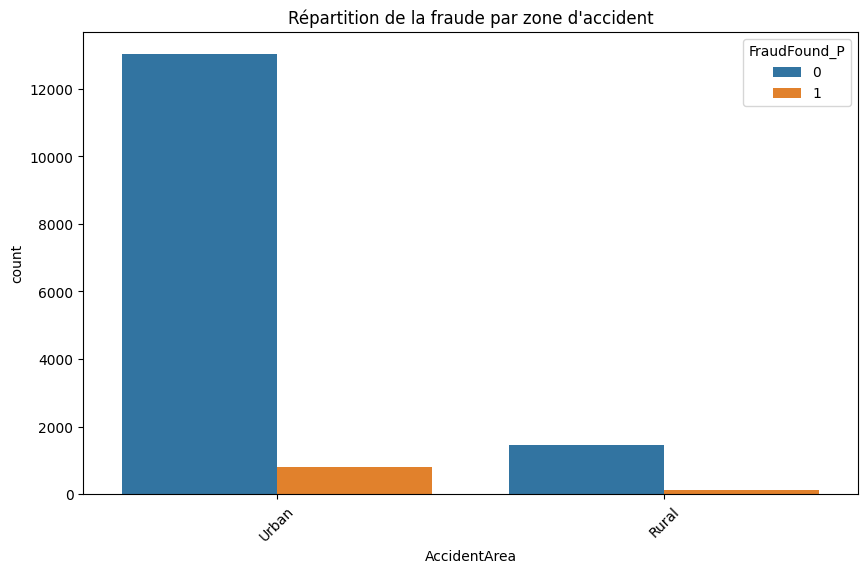

In [15]:
# 4. Visualisation : Fraude par zone d'accident
plt.figure(figsize=(10,6))
sns.countplot(x='AccidentArea', hue='FraudFound_P', data=df)
plt.title("Répartition de la fraude par zone d'accident")
plt.xticks(rotation=45)
plt.show()

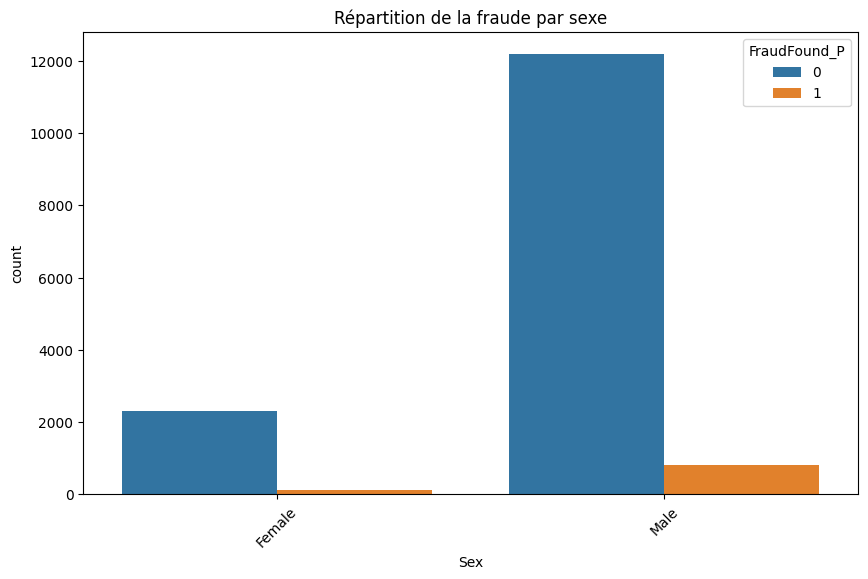

In [16]:
# 4. Visualisation : Fraude par sexe
plt.figure(figsize=(10,6))
sns.countplot(x='Sex', hue='FraudFound_P', data=df)
plt.title('Répartition de la fraude par sexe')
plt.xticks(rotation=45)
plt.show()

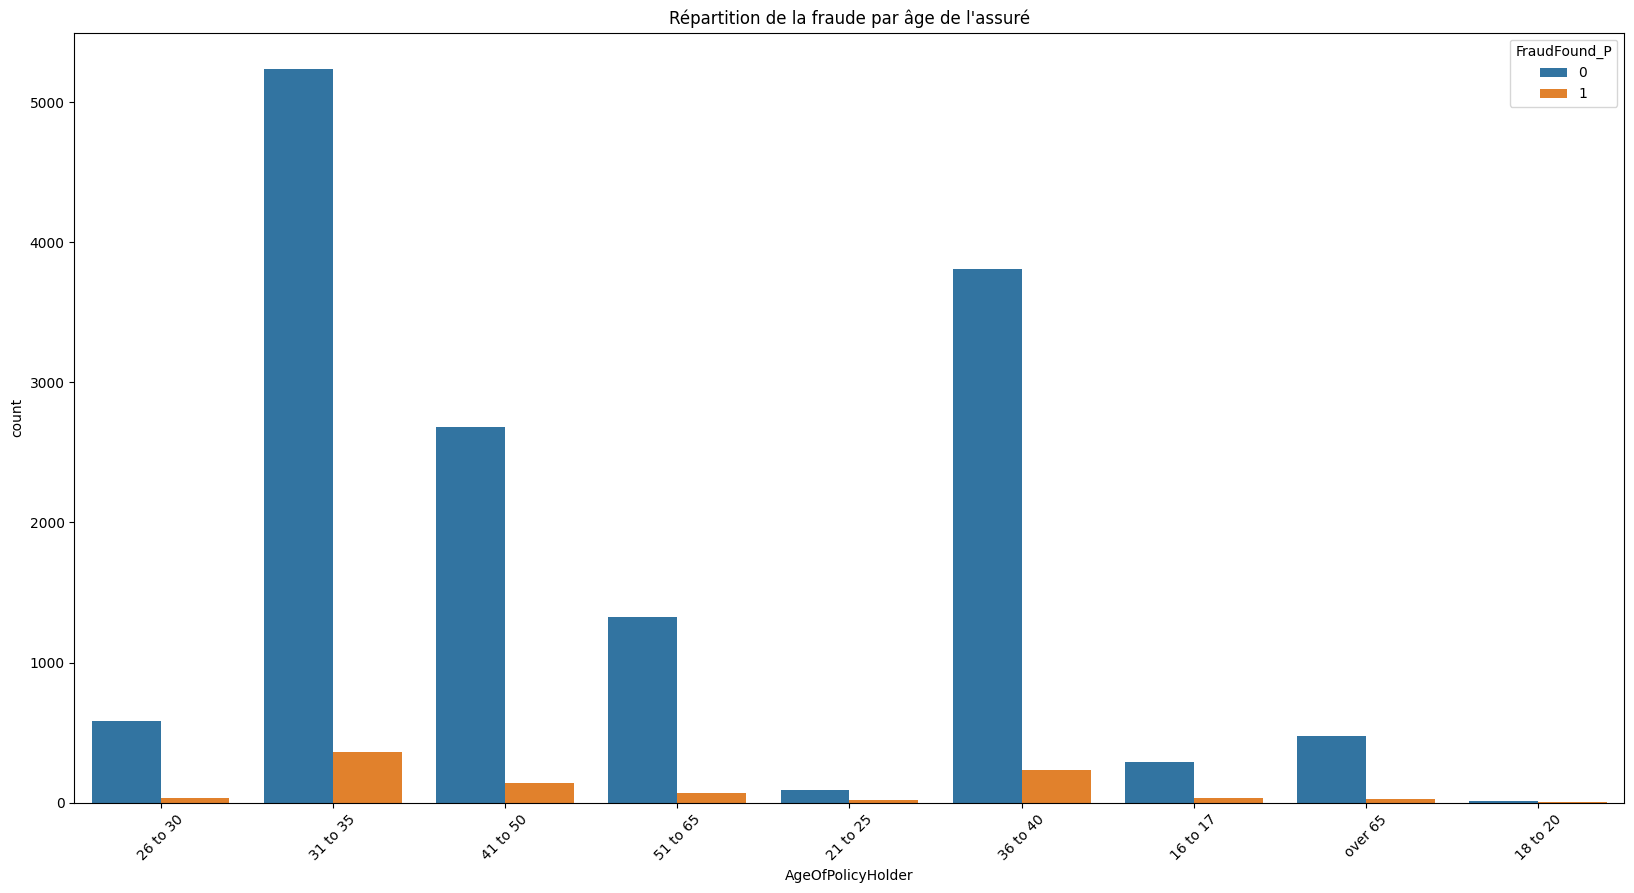

In [17]:
# 4. Visualisation : Fraude par âge de l'assuré
plt.figure(figsize=(20,10))
sns.countplot(x='AgeOfPolicyHolder', hue='FraudFound_P', data=df)
plt.title("Répartition de la fraude par âge de l'assuré")
plt.xticks(rotation=45)
plt.show()

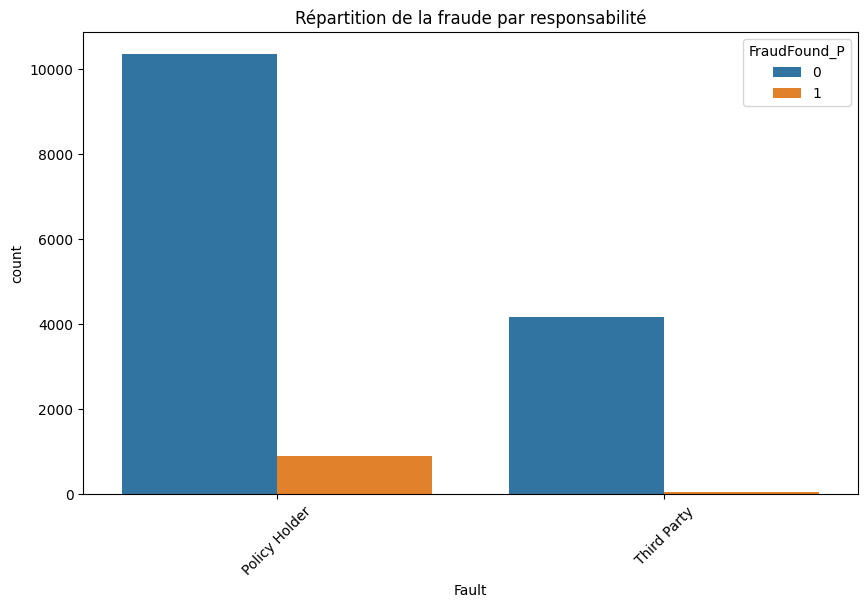

In [18]:
# 4. Visualisation : Fraude par responsabilité
plt.figure(figsize=(10,6))
sns.countplot(x='Fault', hue='FraudFound_P', data=df)
plt.title('Répartition de la fraude par responsabilité')
plt.xticks(rotation=45)
plt.show()

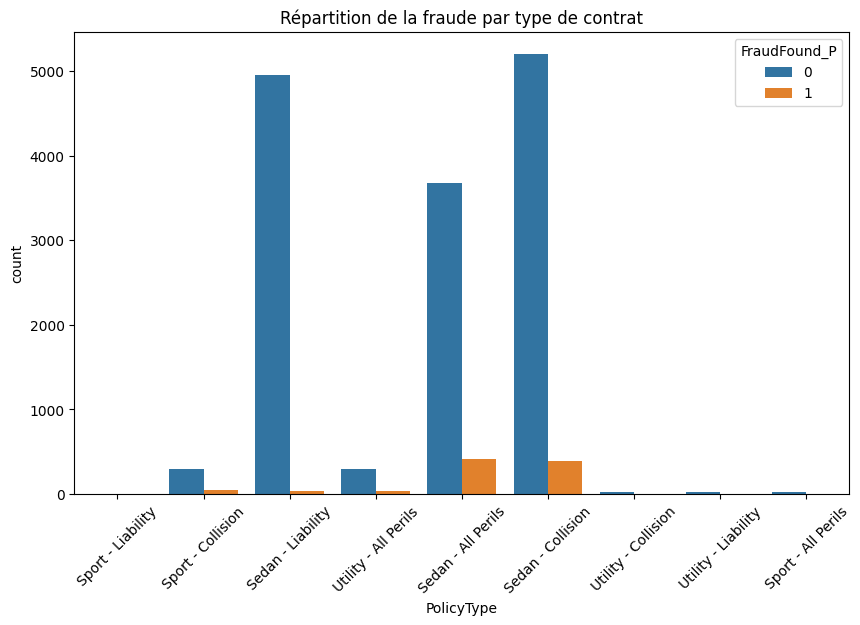

In [19]:
# 4. Visualisation : Fraude par type de contrat
plt.figure(figsize=(10,6))
sns.countplot(x='PolicyType', hue='FraudFound_P', data=df)
plt.title('Répartition de la fraude par type de contrat')
plt.xticks(rotation=45)
plt.show()

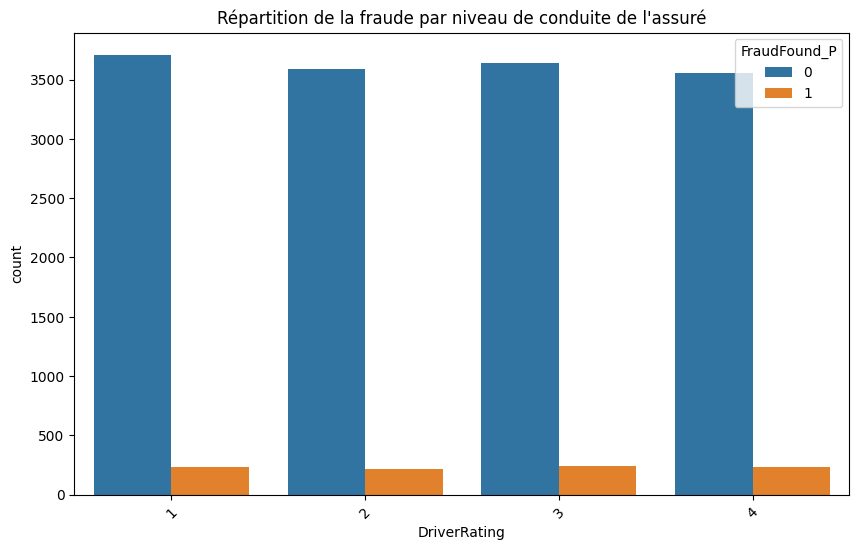

In [20]:
# 4. Visualisation : Fraude par niveau de conduite de l'assuré
plt.figure(figsize=(10,6))
sns.countplot(x='DriverRating', hue='FraudFound_P', data=df)
plt.title("Répartition de la fraude par niveau de conduite de l'assuré")
plt.xticks(rotation=45)
plt.show()

## Data preprocessing

### Données manquantes

In [21]:
detail_nas = pd.concat([df.dtypes,df.isnull().sum()],axis=1)
detail_nas.columns=['FORMAT','NB_NA']
detail_nas

,FORMAT,NB_NA
Month,object,0
WeekOfMonth,int64,0
DayOfWeek,object,0
Make,object,0
AccidentArea,object,0
DayOfWeekClaimed,object,0
MonthClaimed,object,0
WeekOfMonthClaimed,int64,0
Sex,object,0
MaritalStatus,object,0


Il n'y a aucune donnée manquante.

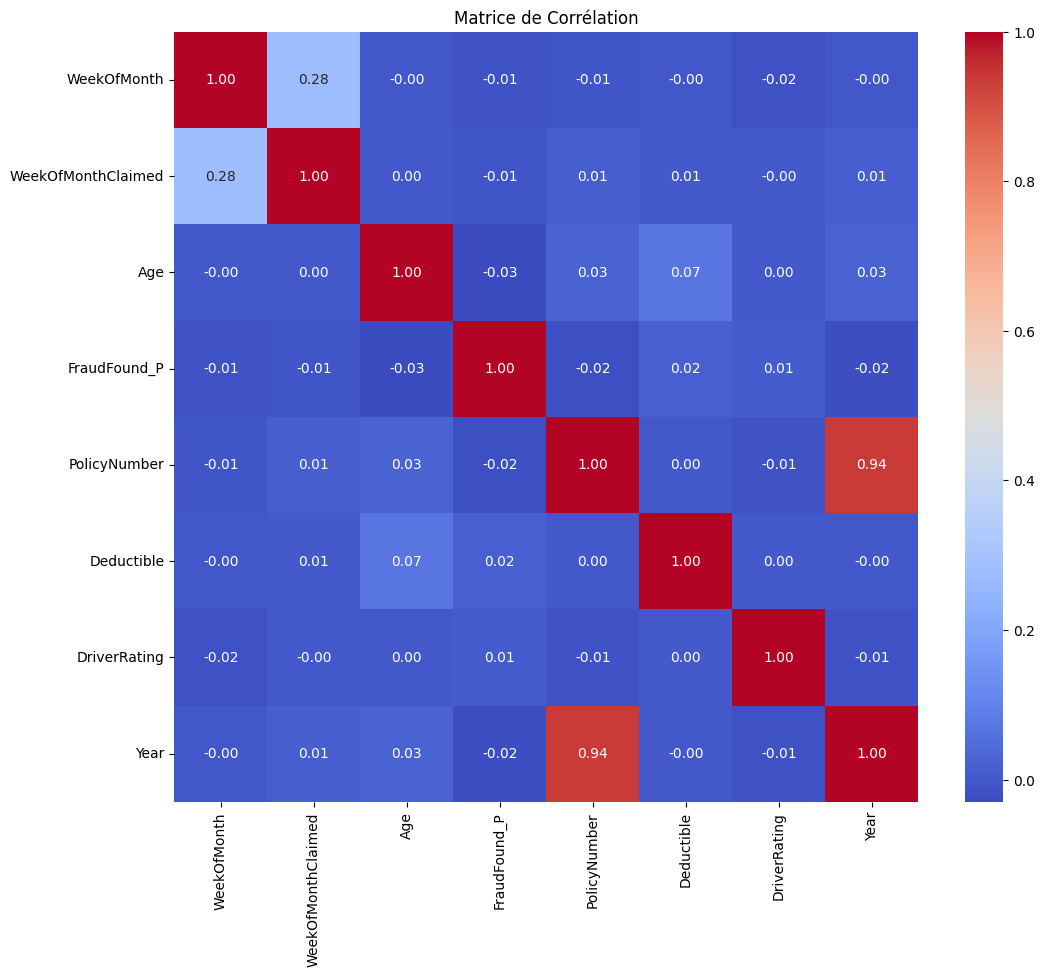

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True,fmt=".2f", cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

On voit qu'il y a une forte correlation entre la variable PolicyNumber et Year. On va supprimer la variable PolicyNumber pour ne garder que la variable Year.

In [23]:

from scipy.stats.contingency import association

#Sélection des variables qualitatives (type 'object')

# On exclut la cible elle-même et les colonnes de type ID ou dates trop complexes
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cols_to_exclude = ['FraudFound_P']
variables_qualitatives = [col for col in cat_cols if col not in cols_to_exclude]

# Calcul du V de Cramer par rapport à 'fraud_reported'
resultats = []
for col in variables_qualitatives:
    # Création du tableau de contingence (croisement des fréquences)
    table = pd.crosstab(df[col], df['FraudFound_P'])

    # Utilisation de la fonction Scipy (Scipy version 1.7.0+)
    v_cramer = association(table, method="cramer")

    resultats.append({
        'Variable': col,
        'V de Cramer': round(v_cramer, 4)
    })

# 5. Création du tableau synthétique trié
tableau_v_cramer = pd.DataFrame(resultats).sort_values(by='V de Cramer', ascending=False)

# Affichage du tableau
print("Association des variables qualitatives avec la fraude (V de Cramer) :")
print(tableau_v_cramer.to_string(index=False))

Association des variables qualitatives avec la fraude (V de Cramer) :
            Variable  V de Cramer
          PolicyType       0.1684
          BasePolicy       0.1616
     VehicleCategory       0.1374
               Fault       0.1314
 AddressChange_Claim       0.0824
        VehiclePrice       0.0663
                Make       0.0623
  PastNumberOfClaims       0.0589
        MonthClaimed       0.0524
   AgeOfPolicyHolder       0.0463
               Month       0.0440
        AgeOfVehicle       0.0377
 NumberOfSuppliments       0.0343
        AccidentArea       0.0335
                 Sex       0.0300
           RepNumber       0.0277
Days_Policy_Accident       0.0274
           DayOfWeek       0.0257
           AgentType       0.0230
    DayOfWeekClaimed       0.0183
   Days_Policy_Claim       0.0178
   PoliceReportFiled       0.0160
        NumberOfCars       0.0125
       MaritalStatus       0.0081
      WitnessPresent       0.0081


On supprime les variables insignifiantes, en dessous de 0.03.

In [24]:
cols_to_drop = [
    'WitnessPresent', 'MaritalStatus', 'PoliceReportFiled', 'NumberOfCars',
    'Days_Policy_Claim', 'Days_Policy_Accident', 'AgentType', 'RepNumber',
    'Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed',
    'WeekOfMonthClaimed', 'PolicyNumber', 'Age'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("Shape après nettoyage :", df.shape)

Shape après nettoyage : (15420, 17)


On supprime les dates car on a déjà les durées correpondantes.
On supprime le numéro de contrat, car il est unique et ne nous donnera aucune indication pour la prédiction.
On supprime la variable âge car une variable catgéorielle avec les tranches d'âge de l'assuré est déjà présente

##Encoding

Nous commençons par réaliser un encodage des variables.

In [25]:
df_encoded = pd.get_dummies(df, drop_first=True)   # one-hot sur les object

X = df_encoded.drop(columns=['FraudFound_P']).values.astype(np.float32)
y = df_encoded['FraudFound_P'].values.astype(np.float32)

## Découpage du dataset

Les données ont été découpées une première fois en :
1. Train : 80 %
2. Test : 20%  

Puis l'échantillon d'entraînement est découpé en :
1.   Train: 75 %
2.   Validation: 25 %



In [26]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
for name, arr in [("Train", X_train), ("Validation", X_valid), ("Test", X_test)]:
    print(f"{name:12} : {arr.shape}")

Train        : (9252, 66)
Validation   : (3084, 66)
Test         : (3084, 66)


## Standardisation

Nous avons ensuite standardisé nos données.

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

## Gestion du déséquilibre des classes

????? jsp quoi mettre

In [28]:
classes      = np.unique(y_train)
weights      = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes.astype(int), weights))
print("\nClass weights :", class_weight)


Class weights : {np.int64(0): np.float64(0.5318464014716027), np.int64(1): np.float64(8.350180505415162)}


# Modèles de Machine Learning


Dans un premier temps, nous avons appliqué des modèles de Machine Learning, à savoir une régression logistique, un Random Forest et enfin un XGBoost.

## Régression Logistique

In [29]:
print("══════════════════════════════════════════════")
print("       RÉGRESSION LOGISTIQUE     ")
print("══════════════════════════════════════════════")

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

#Modélisation de la regression logistique
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average="binary")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

══════════════════════════════════════════════
       RÉGRESSION LOGISTIQUE     
══════════════════════════════════════════════
Accuracy: 0.6132
Precision: 0.1232
Recall: 0.8918
F1-Score: 0.2165


## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

print("══════════════════════════════════════════════")
print("            RANDOM FOREST                    ")
print("══════════════════════════════════════════════")

# Modélisation du Random Forest
# class_weight='balanced' pour gérer le déséquilibre (~6% de fraudes)
# n_estimators=200 : 200 arbres de décision — bon compromis performance/temps
# max_depth=10 : limite la profondeur pour éviter l'overfitting
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# On utilise les données retraitées de la régression logistique
# (même split X_train / X_test avec StandardScaler)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

accuracy_rf = accuracy_score(y_true=y_test, y_pred=y_pred_rf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(
    y_true=y_test, y_pred=y_pred_rf, average='binary')

print(f"Accuracy  : {accuracy_rf:.4f}")
print(f"Precision : {precision_rf:.4f}")
print(f"Recall    : {recall_rf:.4f}")
print(f"F1-Score  : {f1_rf:.4f}")

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Fraud', 'Fraud']))

══════════════════════════════════════════════
            RANDOM FOREST                    
══════════════════════════════════════════════
Accuracy  : 0.6661
Precision : 0.1338
Recall    : 0.8355
F1-Score  : 0.2307

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.66      0.79      3624
       Fraud       0.13      0.84      0.23       231

    accuracy                           0.67      3855
   macro avg       0.56      0.75      0.51      3855
weighted avg       0.93      0.67      0.75      3855



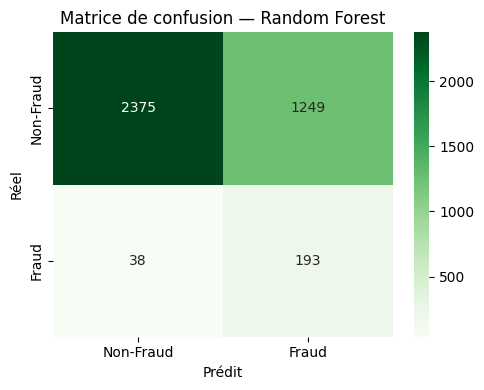

In [31]:
# Matrice de confusion — Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Prédit'); plt.ylabel('Réel')
plt.title('Matrice de confusion — Random Forest')
plt.tight_layout()
plt.show()

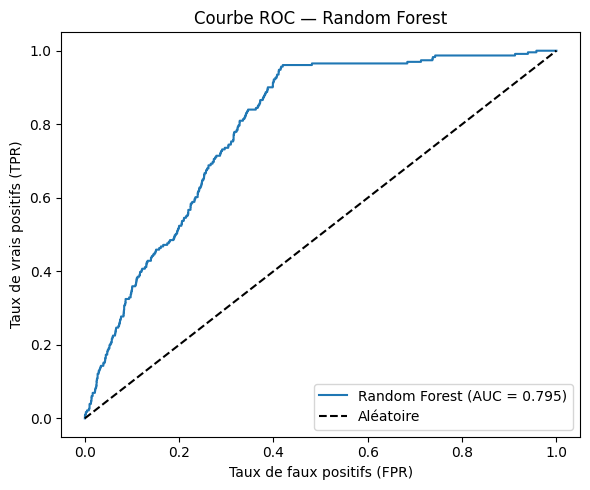


AUC-ROC : 0.7945


In [32]:
# Courbe ROC — Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC — Random Forest')
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_rf:.4f}")

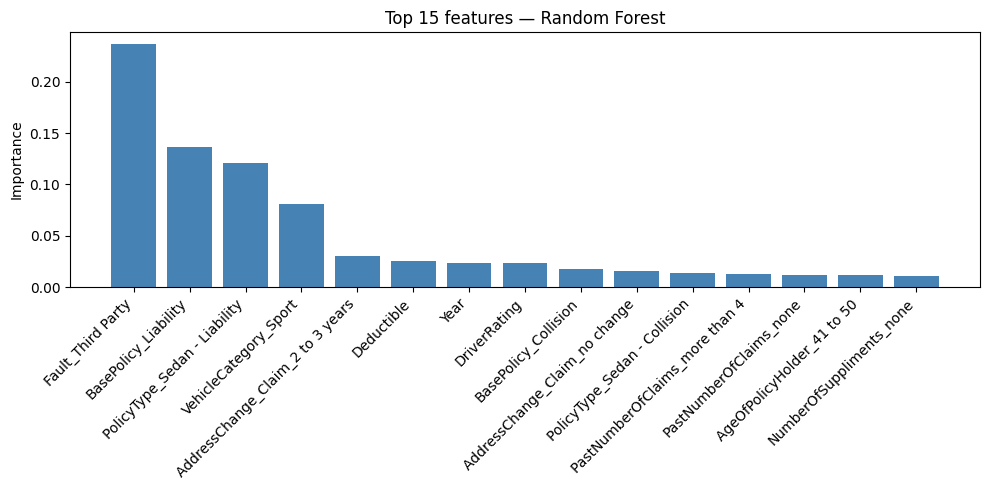

In [33]:
# Importance des variables — Random Forest
# On affiche les 15 features les plus importantes pour interpréter le modèle
feature_names = list(df_encoded.drop(columns=['FraudFound_P']).columns)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10, 5))
plt.bar(range(15), importances[indices], color='steelblue')
plt.xticks(range(15), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title('Top 15 features — Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## XGBoost

In [34]:
from xgboost import XGBClassifier

print("══════════════════════════════════════════════")
print("               XGBOOST                       ")
print("══════════════════════════════════════════════")

# Calcul du ratio négatif/positif pour scale_pos_weight
# Équivalent au class_weight='balanced' pour XGBoost
# scale_pos_weight = nb_négatifs / nb_positifs ≈ 15.7 dans notre dataset
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale = neg / pos
print(f"scale_pos_weight utilisé : {scale:.2f}")

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale,   # gestion du déséquilibre des classes
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

accuracy_xgb = accuracy_score(y_true=y_test, y_pred=y_pred_xgb)
precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(
    y_true=y_test, y_pred=y_pred_xgb, average='binary')

print(f"Accuracy  : {accuracy_xgb:.4f}")
print(f"Precision : {precision_xgb:.4f}")
print(f"Recall    : {recall_xgb:.4f}")
print(f"F1-Score  : {f1_xgb:.4f}")

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Fraud', 'Fraud']))

══════════════════════════════════════════════
               XGBOOST                       
══════════════════════════════════════════════
scale_pos_weight utilisé : 15.71
Accuracy  : 0.7333
Precision : 0.1381
Recall    : 0.6580
F1-Score  : 0.2282

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.74      0.84      3624
       Fraud       0.14      0.66      0.23       231

    accuracy                           0.73      3855
   macro avg       0.55      0.70      0.53      3855
weighted avg       0.92      0.73      0.80      3855



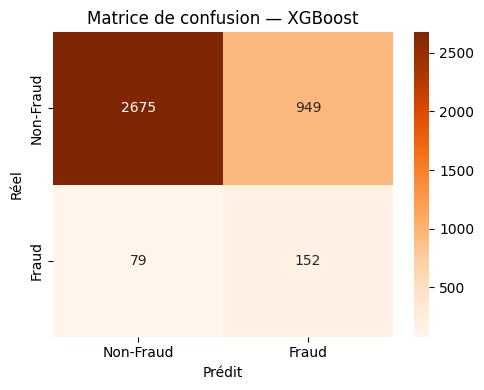

In [35]:
# Matrice de confusion — XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Prédit'); plt.ylabel('Réel')
plt.title('Matrice de confusion — XGBoost')
plt.tight_layout()
plt.show()

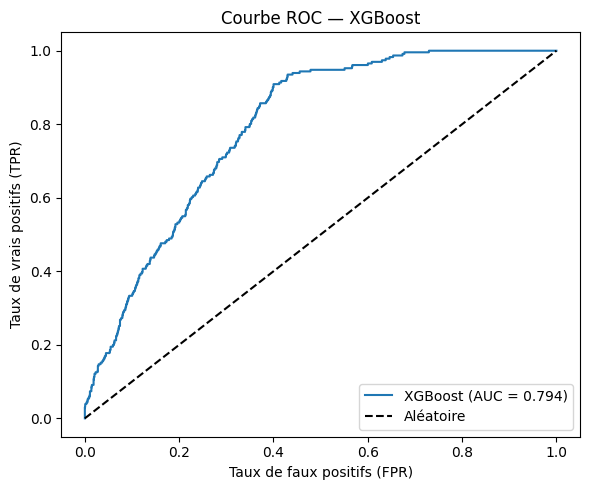


AUC-ROC : 0.7937


In [36]:
# Courbe ROC — XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC — XGBoost')
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_xgb:.4f}")

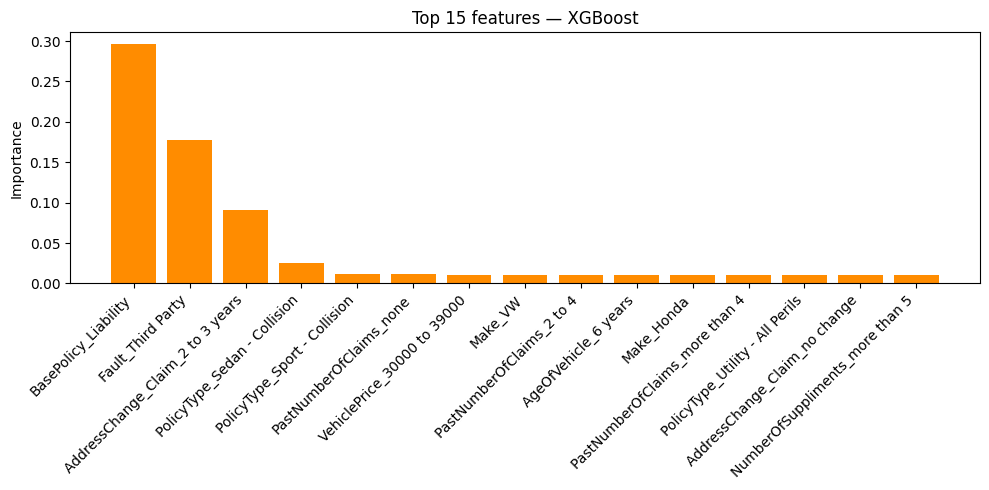

In [37]:
# Importance des variables — XGBoost
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1][:15]

plt.figure(figsize=(10, 5))
plt.bar(range(15), importances_xgb[indices_xgb], color='darkorange')
plt.xticks(range(15), [feature_names[i] for i in indices_xgb], rotation=45, ha='right')
plt.title('Top 15 features — XGBoost')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Comparaison finale des modèles

In [38]:
# ══════════════════════════════════════════════
# COMPARAISON FINALE DES MODÈLES
# ══════════════════════════════════════════════

resultats_comparaison = pd.DataFrame({
    'Modèle'    : ['Régression Logistique', 'Random Forest', 'XGBoost'],
    'Accuracy'  : [accuracy,     accuracy_rf,  accuracy_xgb],
    'Precision' : [precision,    precision_rf, precision_xgb],
    'Recall'    : [recall,        recall_rf,   recall_xgb],
    'F1-Score'  : [f1_score,      f1_rf,       f1_xgb],
    'AUC-ROC'   : [roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]),
                   auc_rf, auc_xgb]
})

resultats_comparaison = resultats_comparaison.set_index('Modèle').round(4)
print(resultats_comparaison.to_string())

                       Accuracy  Precision  Recall  F1-Score  AUC-ROC
Modèle                                                               
Régression Logistique    0.6132     0.1232  0.8918    0.2165   0.7876
Random Forest            0.6661     0.1338  0.8355    0.2307   0.7945
XGBoost                  0.7333     0.1381  0.6580    0.2282   0.7937


Les trois modèles ont une AUC similaire (~0.79), ce qui montre qu’ils ont une capacité de séparation comparable.

La différence principale réside dans le compromis precision / recall :
*   Régression Logistique → maximise le recall
*   XGBoost → maximise l’accuracy
*   Random Forest → meilleur équilibre global  

Aucun modèle ne domine clairement sur toutes les métriques, ce qui justifie d’explorer une approche plus flexible comme le MLP pour tenter d’améliorer la séparation globale et le compromis précision / rappel.

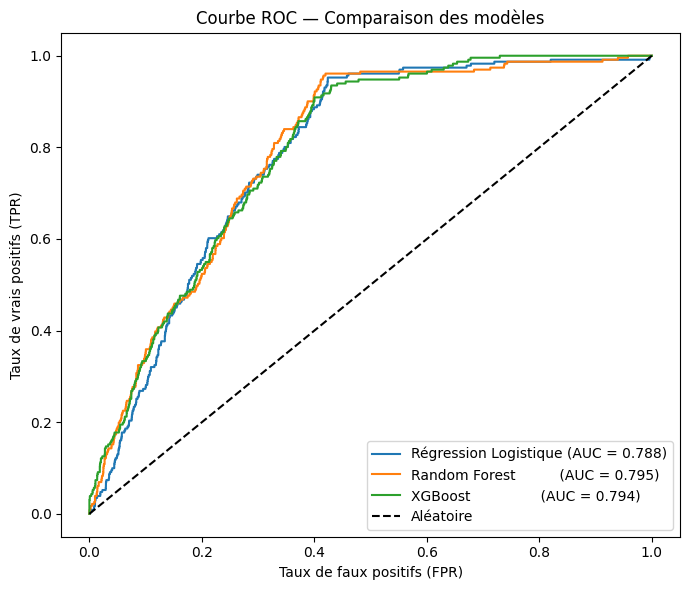

In [39]:
# Courbe ROC comparative — les 3 modèles sur le même graphique
fpr_lr, tpr_lr, _ = roc_curve(y_test,
    model.predict_proba(X_test_scaled)[:, 1])
auc_lr = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f'Régression Logistique (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf,  tpr_rf,  label=f'Random Forest          (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost                (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC — Comparaison des modèles')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Les méthodes traditionnelles présentent certaines limites :


*   La régression logistique est strictement linéaire.

*   Random Forest et XGBoost capturent des non-linéarités mais restent basés sur des partitions d’arbres.
*   Les interactions complexes entre variables catégorielles encodées peuvent être difficiles à modéliser finement.  

Un réseau de neurones (MLP) permettrait d’apprendre des combinaisons non linéaires plus riches , de capturer des interactions complexes entre variables et d’optimiser directement la fonction de perte via descente de gradient

L’objectif est donc de voir si le MLP permet :


*   d’améliorer l’AUC au-delà de 0.79
*   d’obtenir un meilleur compromis precision / recall
*   de mieux séparer les fraudes des non-fraudes










# Modèles de Deep Learning

### Réseaux de neurones denses

Commençons par définir le réseau de neurones suivants:


*   un réseau dense de 256 neurones avec la fonction d'activation ReLu
*   une couche dropout
*   un réseau dense de 128 neurones avec la fonction d'activation ReLu
*   une couche dropout
*   une couche de sortie à 1 neurone avec la fonction d'activation sigmoid
  

Comptons le nombre de paramètres.
*   Pour la première couche : 256 * (66+1) = 17152
*   Pour la deuxième couche : 128 * (256+1) = 32896
*   Pour la dernière couche : 1 * (128+1) = 129

Au total, nous avons : 50 177 paramètres.







In [84]:
 #On recrée les sets de train, validation et test

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# 3. Recalcul des poids
classes = np.unique(y_train)
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes.astype(int), weights))


In [85]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

n_features = X_train.shape[1]
print("Nombre de features :", n_features)

def get_model():
  model = keras.models.Sequential([
        keras.layers.Input(shape=[n_features]),

        keras.layers.Dense(256),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(128),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(1,   activation="sigmoid")
    ])
  return model

def compile_train(optimizer_function, learning_rate, **kwargs):

    metrics = [
          keras.metrics.AUC(name='auc'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.BinaryAccuracy(name='accuracy')]

    optimizer = optimizer_function(learning_rate=learning_rate)
    model = get_model()
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), class_weight=class_weight, **kwargs)
    return model, history
model = get_model()

epochs=20
batch_size=32
learning_rate=1e-3
optimizer=keras.optimizers.SGD

model, history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


Nombre de features : 66
Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7112 - auc: 0.5638 - loss: 0.7129 - recall: 0.3419 - val_accuracy: 0.5003 - val_auc: 0.6268 - val_loss: 0.6988 - val_recall: 0.7228
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5585 - auc: 0.6064 - loss: 0.6868 - recall: 0.5925 - val_accuracy: 0.4614 - val_auc: 0.6623 - val_loss: 0.7242 - val_recall: 0.8424
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5251 - auc: 0.6313 - loss: 0.6730 - recall: 0.6525 - val_accuracy: 0.4912 - val_auc: 0.6855 - val_loss: 0.7015 - val_recall: 0.8370
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5608 - auc: 0.6598 - loss: 0.6475 - recall: 0.6835 - val_accuracy: 0.5016 - val_auc: 0.6999 - val_loss: 0.6918 - val_recall: 0.8533
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5593 - auc: 0.6368 - loss: 0.6745 - recall: 0.6520 - val_accuracy: 0.5272 - val_auc: 0.7120 - val_loss: 0.6745 - val_r

In [86]:
historic = pd.DataFrame(history.history)
historic


,accuracy,auc,loss,recall,val_accuracy,val_auc,val_loss,val_recall
0,0.652075,0.558003,0.714754,0.418773,0.500324,0.626766,0.698776,0.722826
1,0.556636,0.608243,0.680177,0.611913,0.461414,0.662272,0.724199,0.842391
2,0.534263,0.647109,0.669643,0.700361,0.491245,0.685468,0.701518,0.836957
3,0.553178,0.646333,0.659776,0.662455,0.501621,0.699894,0.691815,0.853261
4,0.562473,0.662631,0.654827,0.678700,0.527237,0.711988,0.674510,0.847826
5,0.576524,0.681628,0.642444,0.702166,0.542802,0.720906,0.663975,0.864130
6,0.593385,0.702987,0.628235,0.712996,0.568093,0.727510,0.646162,0.847826
7,0.604194,0.703813,0.627927,0.700361,0.556420,0.733078,0.655158,0.885870
8,0.602356,0.710091,0.623279,0.712996,0.571984,0.737876,0.642724,0.880435
9,0.633268,0.728609,0.609544,0.709386,0.557717,0.741948,0.652715,0.885870


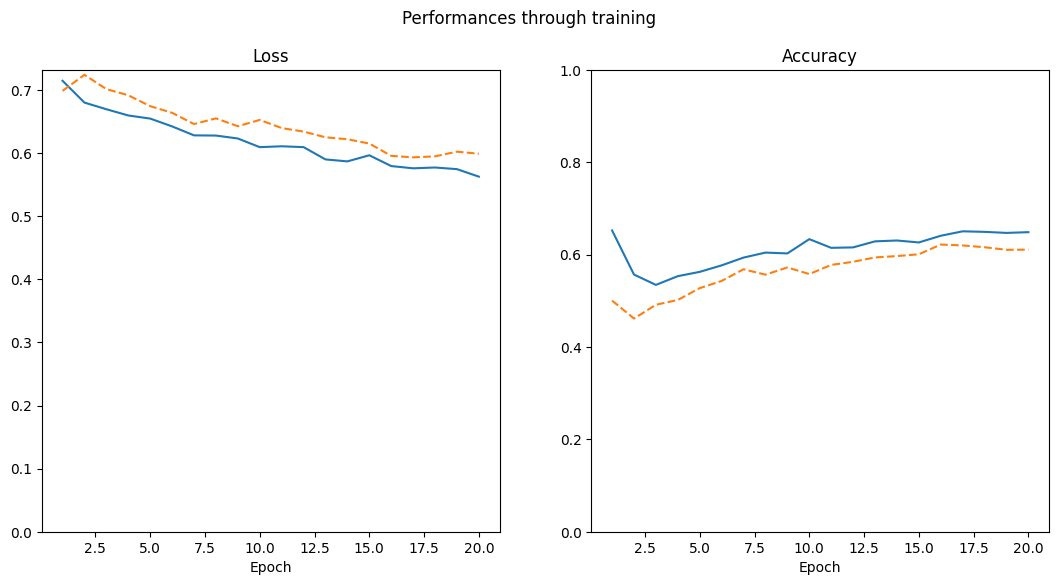

In [87]:
def plot_learning_curves(history, figsize=(13, 6)):
    historic = pd.DataFrame(history.history)
    epochs = [epochs for epochs in range(1, historic.shape[0]+1)]

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, historic["loss"])
    plt.plot(epochs, historic["val_loss"], ls='--')
    plt.xlabel("Epoch")
    plt.ylim(bottom=0)
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, historic["accuracy"])
    plt.plot(epochs, historic["val_accuracy"], ls='--')
    plt.xlabel("Epoch")
    plt.ylim(0, 1)
    plt.title("Accuracy")

    plt.suptitle("Performances through training")
    plt.show()


plot_learning_curves(history)

Nous avons ensuite effectué une prédiction sur le jeu de test.

In [88]:
y_pred_proba = model.predict(X_test).flatten()   # probabilités  [0 ; 1]
y_pred       = (y_pred_proba > 0.5).astype(int)  # seuil 0.5  →  0 ou 1

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"]))

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.58      0.73      2899
       Fraud       0.12      0.90      0.21       185

    accuracy                           0.60      3084
   macro avg       0.55      0.74      0.47      3084
weighted avg       0.94      0.60      0.70      3084



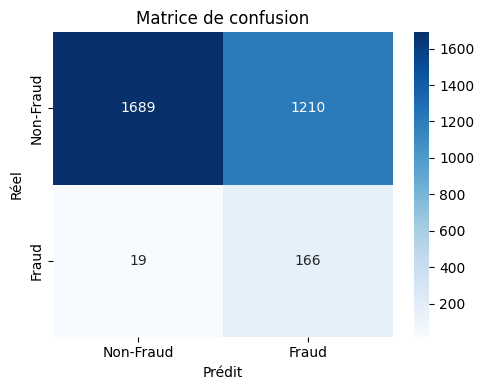

In [89]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

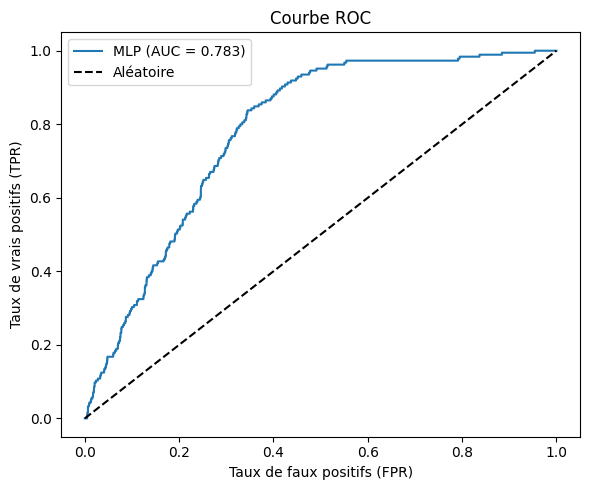


AUC-ROC : 0.7828


In [90]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score   = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_score:.4f}")

## Recherche du meilleur optimizer

En reprenant la logique du TP3, nous avons cherché à comparer les optimizers vu en cours, à savoir SGD, RMSProp, Adam et AdaGrad afin de voir s'il était possible d'améliorer les performances de notre modèle.
Pour cela, nous avons lancé 3 fois les différents schémas d'optimisation.   

In [92]:
n_epochs = 50
batch_size = 528
comparisons_number = 3
learning_rate=5e-4
verbose = 0
results = []


optimizers = [
  keras.optimizers.SGD,
  keras.optimizers.RMSprop,
  keras.optimizers.Adagrad,
  keras.optimizers.Adam
]

for index in range(comparisons_number):
  print("Comparison %d :" % (index+1), end=" ")
  for optimizer in optimizers:
    label = f"{optimizer.__name__} - {learning_rate:.06}"
    print("%s..." % label, end= " ")
    model, history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=n_epochs, verbose=verbose)
    result = {"type": label, "history": pd.DataFrame(history.history)}
    results.append(result)
  print()

Comparison 1 : SGD - 0.0005... RMSprop - 0.0005... Adagrad - 0.0005... Adam - 0.0005... 
Comparison 2 : SGD - 0.0005... RMSprop - 0.0005... Adagrad - 0.0005... Adam - 0.0005... 
Comparison 3 : SGD - 0.0005... RMSprop - 0.0005... Adagrad - 0.0005... Adam - 0.0005... 


In [93]:
def agregate_result(results, network_type, metric_name):
  training = np.zeros((comparisons_number, n_epochs))
  validation = np.zeros((comparisons_number, n_epochs))
  index = 0
  for result in results:
    if result["type"] == network_type:
      historic = result["history"]
      training[index] = historic[metric_name]
      validation[index] = historic["val_%s" % metric_name]
      index += 1
  return training, validation

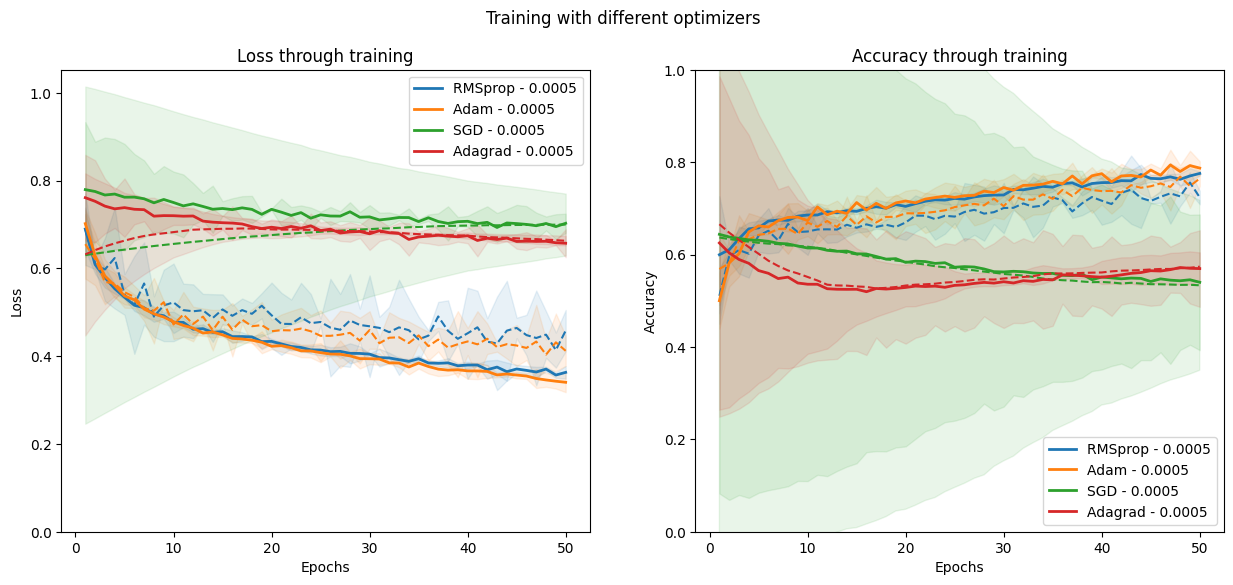

In [94]:
epochs = range(1, n_epochs+1)

figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))

for metric_name, axis in zip(["loss", "accuracy"], [axis_1, axis_2]):

  for index, network_type in enumerate(list(set(result["type"] for result in results))):
    color = sns.color_palette()[index]
    training, validation = agregate_result(results, network_type, metric_name)
    axis.plot(epochs, training.mean(axis=0), lw=2, label=network_type, color=color)
    axis.fill_between(epochs, training.mean(axis=0)-3*training.std(axis=0), training.mean(axis=0)+3*training.std(axis=0), color=color, alpha=0.1)
    axis.plot(epochs, validation.mean(axis=0), ls="--", color=color)
    axis.fill_between(epochs, validation.mean(axis=0)-3*validation.std(axis=0), validation.mean(axis=0)+3*validation.std(axis=0), color=color, alpha=0.1)

  axis.set_ylabel(metric_name.capitalize())
  axis.set_xlabel("Epochs")
  axis.set_title("%s through training" % metric_name.capitalize())
  axis.legend()

  axis_1.set_ylim(bottom=0)
  axis_2.set_ylim(0, 1)


plt.suptitle("Training with different optimizers")
plt.show()

Au vu des graphiques ainsi obtenus, on remarque que Adagrad stagne a cause de la diminution du learning rate, que SGD sur-apprends et que RMS-prop et ADAM sont les optimizers les plus efficaces dans notre cas. On choisi ADAM dans la suite de notre étude

## Etude de la régularisation

On commence par réécrire le MLP avec ADAM et une première régularisation:         keras.layers.BatchNormalization()

In [96]:
n_features = X_train.shape[1]
print("Nombre de features :", n_features)

def get_model():
  model = keras.models.Sequential([
        keras.layers.Input(shape=[n_features]),

        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(1,   activation="sigmoid")
    ])
  return model

def compile_train(optimizer_function, learning_rate, **kwargs):

    metrics = [
          keras.metrics.AUC(name='auc'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.BinaryAccuracy(name='accuracy')]

    optimizer = optimizer_function(learning_rate=learning_rate)
    model = get_model()
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), class_weight=class_weight, **kwargs)
    return model, history
model = get_model()

epochs=20
batch_size=32
learning_rate=1e-3
optimizer=keras.optimizers.Adam

model_ADAM_regu, history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Nombre de features : 66
Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6353 - auc: 0.6620 - loss: 0.7088 - recall: 0.6414 - val_accuracy: 0.6628 - val_auc: 0.7788 - val_loss: 0.5366 - val_recall: 0.8315
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6853 - auc: 0.8004 - loss: 0.5250 - recall: 0.7962 - val_accuracy: 0.6216 - val_auc: 0.7904 - val_loss: 0.6346 - val_recall: 0.8967
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6523 - auc: 0.8226 - loss: 0.5075 - recall: 0.8986 - val_accuracy: 0.6355 - val_auc: 0.7859 - val_loss: 0.5434 - val_recall: 0.8804
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6877 - auc: 0.8358 - loss: 0.4598 - recall: 0.8561 - val_accuracy: 0.6261 - val_auc: 0.7945 - val_loss: 0.5836 - val_recall: 0.9130
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6762 - auc: 0.8516 - loss: 0.4419 - recall: 0.8773 - val_accuracy: 0.6735 - val_auc: 0.8005 - val_loss: 0.4844 - va

On refait ensuite les prédictions et on compare avec le MLP initial

In [97]:
y_pred_proba_2 = model_ADAM_regu.predict(X_test).flatten()   # probabilités  [0 ; 1]
y_pred_2       = (y_pred_proba_2 > 0.5).astype(int)  # seuil 0.5  →  0 ou 1

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_2, target_names=["Non-Fraud", "Fraud"]))

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.75      0.85      2899
       Fraud       0.15      0.72      0.25       185

    accuracy                           0.74      3084
   macro avg       0.57      0.74      0.55      3084
weighted avg       0.93      0.74      0.81      3084



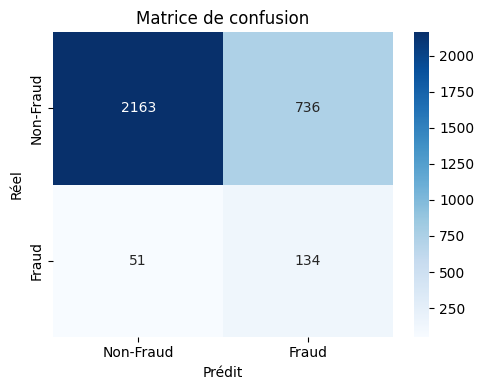

In [98]:
cm = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

Comparaison des courbes ROC

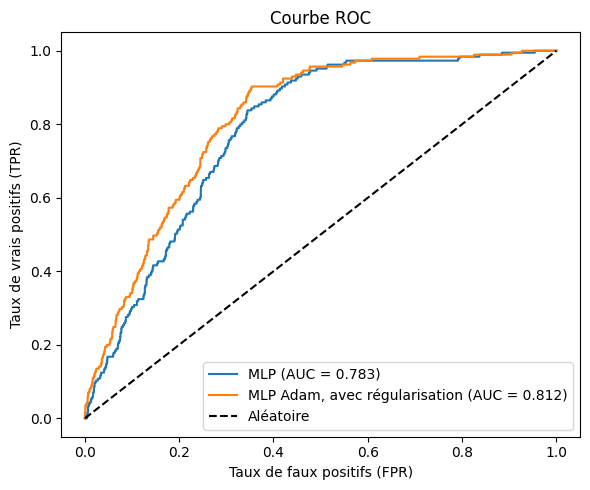


AUC-ROC : 0.7828


In [99]:
fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba_2)
auc_score2   = roc_auc_score(y_test, y_pred_proba_2)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.3f})")
plt.plot(fpr2, tpr2, label=f"MLP Adam, avec régularisation (AUC = {auc_score2:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_score:.4f}")

## Weight Decay

La dernière manière de régulariser vue en cours est le Weight Decay, que nous pouvons essayer d'implémenter. En théorie, AdamW va permettre d'empêcher notre modèle de sur-apprendre, surtout que notre dataset est très déséquilibré

In [106]:
n_features = X_train.shape[1]
print("Nombre de features :", n_features)

def get_model():
  model = keras.models.Sequential([
        keras.layers.Input(shape=[n_features]),

        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(1,   activation="sigmoid")
    ])
  return model

def compile_train(optimizer_function, learning_rate, **kwargs):

    weight_decay = 1e-4

    metrics = [
          keras.metrics.AUC(name='auc'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.BinaryAccuracy(name='accuracy')]

    optimizer = optimizer_function(learning_rate=learning_rate, weight_decay=weight_decay)
    model = get_model()
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), class_weight=class_weight, **kwargs)
    return model, history
model = get_model()

epochs=20
batch_size=32
learning_rate=1e-3
optimizer=keras.optimizers.AdamW

model_ADAMW_regu, history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Nombre de features : 66
Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6058 - auc: 0.6558 - loss: 0.6980 - recall: 0.6142 - val_accuracy: 0.6417 - val_auc: 0.7703 - val_loss: 0.6182 - val_recall: 0.8424
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6861 - auc: 0.7834 - loss: 0.5432 - recall: 0.7317 - val_accuracy: 0.6644 - val_auc: 0.7772 - val_loss: 0.5737 - val_recall: 0.7935
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6709 - auc: 0.8245 - loss: 0.5042 - recall: 0.8238 - val_accuracy: 0.6660 - val_auc: 0.7886 - val_loss: 0.5156 - val_recall: 0.8043
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7005 - auc: 0.8491 - loss: 0.4525 - recall: 0.8698 - val_accuracy: 0.6446 - val_auc: 0.7936 - val_loss: 0.5198 - val_recall: 0.8804
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6909 - auc: 0.8558 - loss: 0.4501 - recall: 0.9135 - val_accuracy: 0.6404 - val_auc: 0.7946 - val_loss: 0.5174 - v

In [113]:
y_pred_proba_3 = model_ADAMW_regu.predict(X_test).flatten()   # probabilités  [0 ; 1]
y_pred_3       = (y_pred_proba_3 > 0.5).astype(int)  # seuil 0.5  →  0 ou 1

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_3, target_names=["Non-Fraud", "Fraud"]))

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.76      0.86      2899
       Fraud       0.15      0.64      0.24       185

    accuracy                           0.76      3084
   macro avg       0.56      0.70      0.55      3084
weighted avg       0.92      0.76      0.82      3084



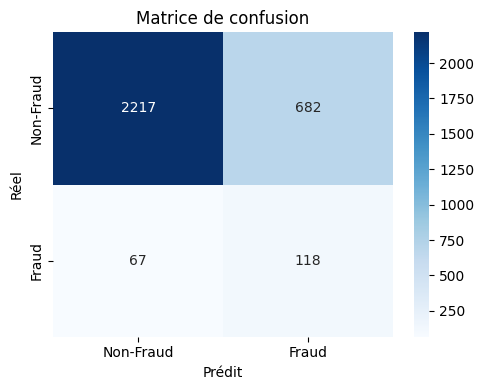

In [114]:
cm = confusion_matrix(y_test, y_pred_3)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

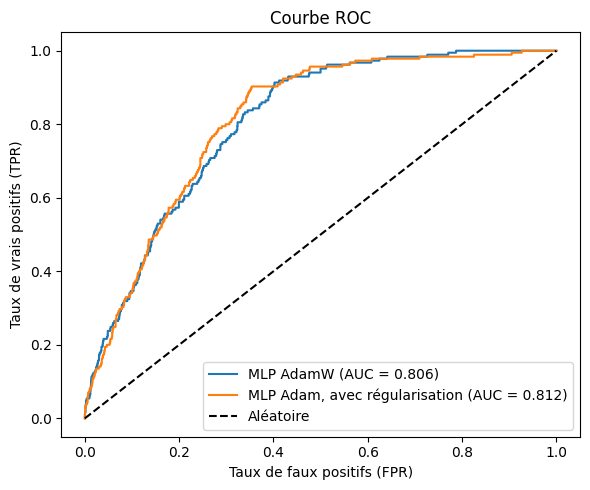


AUC-ROC : 0.7828


In [115]:
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_3)
auc_score3   = roc_auc_score(y_test, y_pred_proba_3)

plt.figure(figsize=(6, 5))
plt.plot(fpr3, tpr3, label=f"MLP AdamW (AUC = {auc_score3:.3f})")
plt.plot(fpr2, tpr2, label=f"MLP Adam, avec régularisation (AUC = {auc_score2:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_score:.4f}")

On remarque que AdamW (weight decay qui correspond au la régularisation L2 n'apporte pas tant d'amélioration que ça, on reste avec Adam pour la suite des comparaisons

## Early Stopping

On peut aussi essayer d'ajouter un early stopping. On fait la mesure d'arrêt sur AUC car c'est la métrique la plus importante dans le cas de détection de fraude. Quitte à avoir une précision un peu plus faible, le compromis sera meilleur si on détecte plus de fraude dans l'absolu

In [102]:
from tensorflow.keras.callbacks import EarlyStopping

n_features = X_train.shape[1]
print("Nombre de features :", n_features)

def get_model():
  model = keras.models.Sequential([
        keras.layers.Input(shape=[n_features]),

        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(1,   activation="sigmoid")
    ])
  return model

def compile_train(optimizer_function, learning_rate, **kwargs):

    #On ajoute l'early stopping et on peut mettre plein d'epoque pour tester

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10,
        restore_best_weights=True
    )


    metrics = [
          keras.metrics.AUC(name='auc'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.BinaryAccuracy(name='accuracy')]

    optimizer = optimizer_function(learning_rate=learning_rate)
    model = get_model()
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), class_weight=class_weight, callbacks=[early_stop], **kwargs)
    return model, history
model = get_model()

epochs=100 # On peut maintenant augmenter le nombre d'époque sans risque
batch_size=32
learning_rate=1e-3
optimizer=keras.optimizers.Adam

model_ADAM_regu_ES, history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Nombre de features : 66
Epoch 1/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.5731 - auc: 0.6450 - loss: 0.7007 - recall: 0.6364 - val_accuracy: 0.6511 - val_auc: 0.7795 - val_loss: 0.6019 - val_recall: 0.8315
Epoch 2/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6702 - auc: 0.8057 - loss: 0.5237 - recall: 0.8132 - val_accuracy: 0.6436 - val_auc: 0.7948 - val_loss: 0.5562 - val_recall: 0.8804
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6869 - auc: 0.8303 - loss: 0.4866 - recall: 0.8414 - val_accuracy: 0.6287 - val_auc: 0.7922 - val_loss: 0.5787 - val_recall: 0.9022
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6683 - auc: 0.8302 - loss: 0.4716 - recall: 0.8771 - val_accuracy: 0.6333 - val_auc: 0.7932 - val_loss: 0.5948 - val_recall: 0.8913
Epoch 5/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6744 - auc: 0.8353 - loss: 0.4663 - recall: 0.8583 - val_accuracy: 0.6582 - val_auc: 0.7954 - val_loss: 0.50

Comparaison des modèles :

In [107]:
y_pred_proba_4 = model_ADAM_regu_ES.predict(X_test).flatten()   # probabilités  [0 ; 1]
y_pred_4       = (y_pred_proba_4 > 0.5).astype(int)  # seuil 0.5  →  0 ou 1

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_4, target_names=["Non-Fraud", "Fraud"]))

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.64      0.77      2899
       Fraud       0.13      0.89      0.23       185

    accuracy                           0.65      3084
   macro avg       0.56      0.76      0.50      3084
weighted avg       0.94      0.65      0.74      3084



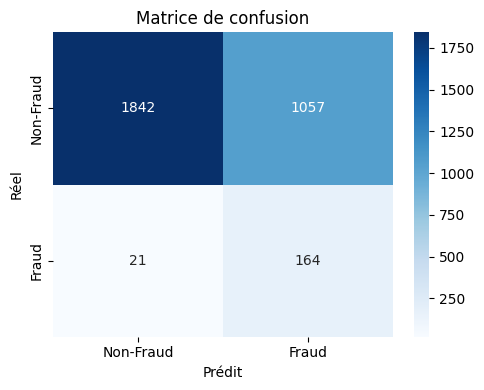

In [108]:
cm = confusion_matrix(y_test, y_pred_4)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

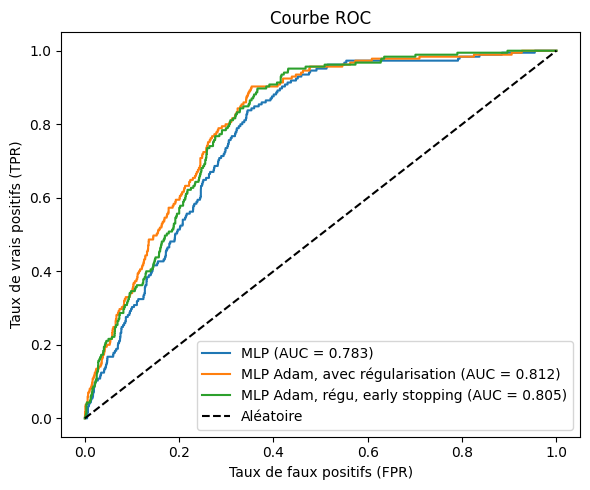

In [109]:
fpr4, tpr4, _ = roc_curve(y_test, y_pred_proba_4)
auc_score4   = roc_auc_score(y_test, y_pred_proba_4)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.3f})")
plt.plot(fpr2, tpr2, label=f"MLP Adam, avec régularisation (AUC = {auc_score2:.3f})")
plt.plot(fpr4, tpr4, label=f"MLP Adam, régu, early stopping (AUC = {auc_score4:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(); plt.tight_layout()
plt.show()


On remarque que le early stopping sur la val_auc n'est pas forcément pertinent avec notre dataset et notre modèle, 20 époques (nombre choisi arbitrairement au début) suffisait déja à bien entrainer notre modèle. Il s'agit encore une fois de choisir le compromis voulu entre les faux positifs et la précision de fraude détéctée. La matrice de confusion montre bien que notre modele avec early stopping capture beaucoup plus de fraude, mais le nombre de faux positif augmente

- 30 Fraude en plus de trouvées
- 300 Faux positifs en plus


## Ajout de l'échéancier

Ajouter un échéancier permet d'améliorer la précision en cas de fonction de loss complexe, ça évite au réseau de "sauter" par dessus le point optimal

In [127]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def compile_train(optimizer_function, learning_rate, **kwargs):

    #ajout de l'échéancier
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr = 1e-6,
        verbose=1
    )

    metrics = [
          keras.metrics.AUC(name='auc'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.BinaryAccuracy(name='accuracy')]

    optimizer = optimizer_function(learning_rate=learning_rate)
    model = get_model()
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), class_weight=class_weight, callbacks=[lr_scheduler] , **kwargs)
    return model, history
model = get_model()

epochs=20
batch_size=32
learning_rate=1e-3
optimizer=keras.optimizers.Adam

model_ADAM_Echancier, history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5731 - auc: 0.6895 - loss: 0.6839 - recall: 0.7297 - val_accuracy: 0.7124 - val_auc: 0.7805 - val_loss: 0.4837 - val_recall: 0.7391 - learning_rate: 0.0010
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7032 - auc: 0.8070 - loss: 0.5222 - recall: 0.7930 - val_accuracy: 0.6245 - val_auc: 0.7843 - val_loss: 0.5962 - val_recall: 0.8913 - learning_rate: 0.0010
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6689 - auc: 0.8082 - loss: 0.5215 - recall: 0.8271 - val_accuracy: 0.6466 - val_auc: 0.7899 - val_loss: 0.5006 - val_recall: 0.8696 - learning_rate: 0.0010
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6753 - auc: 0.8358 - loss: 0.4718 - recall: 0.8501 - val_accuracy: 0.6530 - val_auc: 0.7920 - val_loss: 0.5118 - val_recall: 0.8587 - learning_rate: 0.0010
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6963 - auc: 0.8590 - loss: 0.4504 - recall: 

In [128]:
y_pred_proba_5 = model_ADAM_Echancier.predict(X_test).flatten()   # probabilités  [0 ; 1]
y_pred_5       = (y_pred_proba_5 > 0.5).astype(int)  # seuil 0.5  →  0 ou 1

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_5, target_names=["Non-Fraud", "Fraud"]))

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.74      0.84      2899
       Fraud       0.15      0.72      0.25       185

    accuracy                           0.74      3084
   macro avg       0.56      0.73      0.54      3084
weighted avg       0.93      0.74      0.81      3084



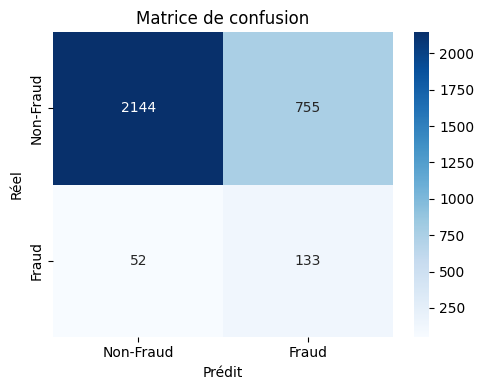

In [129]:
cm = confusion_matrix(y_test, y_pred_5)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

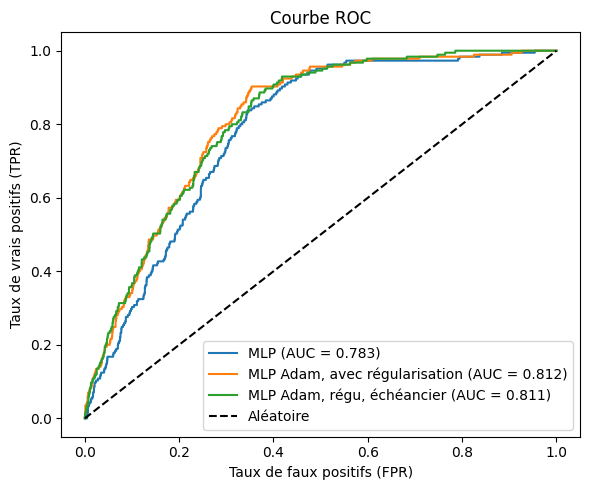

In [131]:
fpr5, tpr5, _ = roc_curve(y_test, y_pred_proba_5)
auc_score5   = roc_auc_score(y_test, y_pred_proba_5)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.3f})")
plt.plot(fpr2, tpr2, label=f"MLP Adam, avec régularisation (AUC = {auc_score2:.3f})")
plt.plot(fpr5, tpr5, label=f"MLP Adam, régu, échéancier (AUC = {auc_score5:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(); plt.tight_layout()
plt.show()

On remarque que  l'échancier n'apporte ici aussi presque aucune différence avec le MLP régularisé par batch Normalisation et Batch Dropout. L'optimisation par Adam est déja très performante et l'échéancier est négligeable.

De plus, on utilise ici un échéancier adaptatif, ce qui diffère légèrement des méthodes vues en cours, qui sont statique dans l'évolution du learning rate

## Tableau comparatif
|Méthode|Vrai positifs|Faux positifs|AUC|Accuracy|Recall|
|-------|-------------|-------------|---|--------|------|
|MLP DE BASE| 166|1210|0.78|0.64|0.813|
|Adam + BatchDropout et Normalisation|134|736|0.91|0.756|0.92|
|Adam +Weight Decay|118|682|0.89|0.745|0.896|
|Adam +Early Stopping|164|1057|0.891|0.72|0.9|
|Adam + BatchDropout et Normalisation + Echeancier|133|755|0.9|0.77|0.93|
|XGBoost|||0.79|0.73|0.66|

Tout d'abord, on observe que la régularisation permet une chute drastique des faux positifs, mais en compromis, on détecte légèrement moins de fraude. Le plus équilibré est la version avec échéancier (meilleure accuracy et meilleur recall).

La version qui est la plus précise sur les fraude uniquement est la version early stopping, qui détecte 164 fraude mais avec 200 faux positifs de moins que la version de base.

Celle qui génère le moins d'enquète sur des clients honnètes (moins de faux positifs) est la version weight decay, mais elle est plus permissive sur les fraudes, en laisse passer beaucoup plus.

Finalement, tout est une question de compromis est d'objectif que l'assurance se fixe avec sa politique anti fraude.
